<div style="text-align: center;">
  <h1><b>Exploratory Data Analysis (EDA)</b></h1>
  <hr>
</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder

splits = {'train': 'train.csv', 'validation': 'valid.csv', 'test': 'test.csv'}
df = pd.read_csv("hf://datasets/bdotloh/empathetic-dialogues-contexts/" + splits["train"])

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:

# 1. Check for missing values
df.isnull().sum()


,0
Unnamed: 0,0
situation,0
emotion,0
text_length,0
emotion_encoded,0


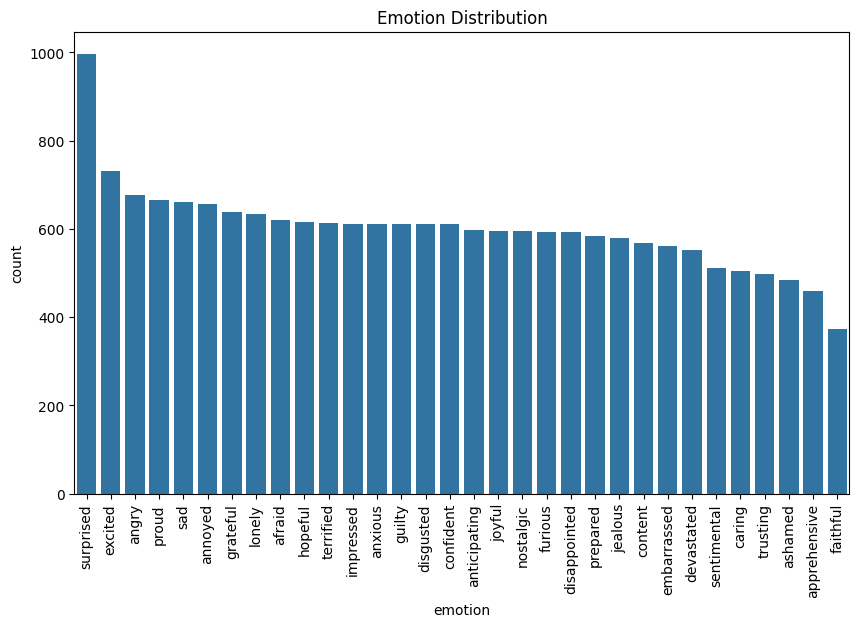

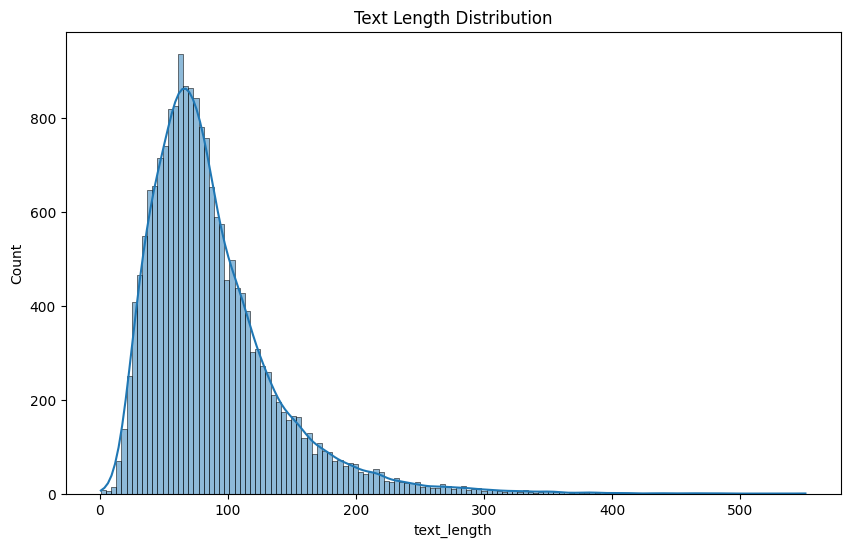

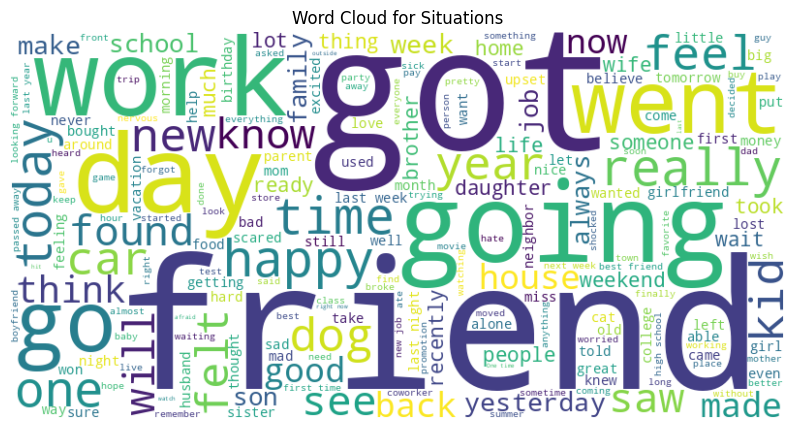

In [ ]:
# 3. Emotion Distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index)
plt.title('Emotion Distribution')
plt.xticks(rotation=90)
plt.show()

# 4. Text Length Distribution in 'situation'
df['text_length'] = df['situation'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], kde=True)
plt.title('Text Length Distribution')
plt.show()

# 5. Word Cloud for 'situation' column (Top words)
text = ' '.join(df['situation'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Situations')
plt.show()

In [ ]:
# 6. Encoding the emotion column (Label Encoding)
le = LabelEncoder()
df['emotion_encoded'] = le.fit_transform(df['emotion'])

# 7. Check the first few rows after encoding
print("\nEncoded Data:")
df.head()


Encoded Data:


,Unnamed: 0,situation,emotion,text_length,emotion_encoded
0,0,I remember going to the fireworks with my best...,sentimental,120,28
1,1,i used to scare for darkness,afraid,29,0
2,2,I showed a guy how to run a good bead in weldi...,proud,78,26
3,3,I have always been loyal to my wife.,faithful,36,15
4,4,A recent job interview that I had made me feel...,terrified,103,30



<div style="text-align: center;">
  <h1><b>Fine Tuning Data with Meta-Llama-3.1-8B using unsloth</b></h1>
  <hr>
</div>

In [ ]:
%%capture
!pip install unsloth "xformers==0.0.28.post2"
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

**Base Model:** Built on **Meta-Llama-3.1-8B**, a powerful open-source language model.  
**Optimization Framework:** Leveraged **FastLanguageModel** for hardware-efficient optimization and improved performance.  

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.1: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.12.1 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [4]:
from datasets import load_dataset

ds = load_dataset("bdotloh/empathetic-dialogues-contexts")

README.md:   0%|          | 0.00/540 [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/1.99M [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/298k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/319k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19209 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2756 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2542 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'situation', 'emotion'],
        num_rows: 19209
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'situation', 'emotion'],
        num_rows: 2756
    })
    test: Dataset({
        features: ['Unnamed: 0', 'situation', 'emotion'],
        num_rows: 2542
    })
})

**Formatting:** 

The dataset was formatted using `formatting_prompts_func` to pair emotions with their respective context.  Empathetic Explanations Included tailored empathetic responses for over 30 distinct emotions, ensuring dynamic and context-aware outputs.  


In [2]:
def formatting_prompts_func(examples):
    texts = examples["situation"]
    emotions = examples["emotion"]
    formatted_texts = []

    def generate_empathy(emotion, text):
        # Predefined empathetic responses based on expanded emotion types
        base_responses = {
            "sentimental": "It seems like you're reflecting deeply. Cherish the memories or thoughts you're revisiting.",
            "afraid": "Feeling afraid can be overwhelming. Take small steps to face your fears, and remember you're not alone.",
            "proud": "You should feel proud! Celebrate your achievements and acknowledge your hard work.",
            "faithful": "Staying faithful shows great strength. Trust in your beliefs, and keep moving forward.",
            "terrified": "Being terrified can be paralyzing. Try grounding yourself with deep breaths and focusing on the present.",
            "joyful": "Joy is a wonderful emotion! Embrace it fully and share it with others around you.",
            "angry": "Anger can be powerful. Take a moment to breathe and find a healthy way to express it.",
            "sad": "It's okay to feel sad. Allow yourself to process your emotions and seek comfort if needed.",
            "jealous": "Jealousy can be challenging. Reflect on your feelings and focus on your strengths.",
            "grateful": "Gratitude is a beautiful thing. Cherish the moments or people you're thankful for.",
            "prepared": "Feeling prepared is empowering. Trust your readiness and take on the challenge with confidence.",
            "embarrassed": "It's okay to feel embarrassed; it happens to everyone. Learn from the experience and move on.",
            "excited": "Excitement is contagious! Enjoy the anticipation and the moment ahead.",
            "annoyed": "Feeling annoyed can be frustrating. Take a moment to step back and find your calm.",
            "lonely": "Loneliness can feel heavy. Reach out to someone or engage in something you enjoy.",
            "ashamed": "Shame can be tough to navigate. Be kind to yourself and remember that everyone makes mistakes.",
            "guilty": "Guilt can be a sign of your strong values. Take steps to make amends if needed.",
            "surprised": "Surprise can bring a mix of emotions. Embrace the unexpected with curiosity.",
            "nostalgic": "Nostalgia can be bittersweet. Relish the good memories and carry them forward.",
            "confident": "Confidence is key! Trust in yourself and keep shining.",
            "furious": "Fury can feel consuming. Take time to cool off and think about your next steps.",
            "disappointed": "Disappointment is a part of life. Reflect on it, and remember there's always another opportunity.",
            "caring": "Caring for others is a beautiful trait. Don't forget to care for yourself as well.",
            "trusting": "Trusting others shows strength. Build on that trust to deepen your connections.",
            "disgusted": "Disgust is a strong reaction. Reflect on what caused it and decide how to respond.",
            "anticipating": "Anticipation can be exciting or nerve-wracking. Stay grounded as you look forward.",
            "anxious": "Anxiety can feel overwhelming. Take deep breaths and focus on what you can control.",
            "hopeful": "Hope is a powerful motivator. Hold onto it as you work toward your goals.",
            "content": "Contentment is a gift. Enjoy the peace and satisfaction of the moment.",
            "impressed": "Being impressed shows admiration. Let it inspire you to reach new heights.",
            "apprehensive": "Apprehension is natural. Prepare yourself and take it one step at a time.",
            "devastated": "Devastation can feel insurmountable. Reach out for support, and take things one day at a time.",
        }

        # Adding cultural context dynamically
        cultural_cues = {
            "family": "It's natural to feel connected to family in this context. Lean on them for support if possible.",
            "work": "Balancing work and emotions can be challenging. Consider taking a short break to reset your thoughts.",
            "health": "Health is a sensitive topic. Remember, taking proactive steps and reaching out for help can make a difference.",
        }

        # Dynamic adjustment based on keywords in text
        for cue, cue_response in cultural_cues.items():
            if cue in text.lower():
                base_responses[emotion] = f"{base_responses.get(emotion, '')} {cue_response}"

        # Return a tailored empathetic response
        return base_responses.get(emotion, "Emotions are complex, and it's great that you're acknowledging them.")

    for text, emotion in zip(texts, emotions):
        # Handle empty text or emotion
        text = text.strip() or "No text provided."
        emotion = emotion or "an unspecified emotion"

        # Generate an empathetic response
        empathetic_response = f"I can sense that the text expresses {emotion}. {generate_empathy(emotion, text)}"

        # Format the prompt
        formatted_text = f"""Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Identify the emotion conveyed in the following text and provide an empathetic explanation.

### Input:
{text}

### Response:
{empathetic_response}{getattr(tokenizer, 'eos_token', '<|endoftext|>')}"""
        formatted_texts.append(formatted_text)

    # Return formatted text examples
    return {"text": formatted_texts}


In [6]:
formatted_dataset = ds.map(formatting_prompts_func, batched=True)

Map:   0%|          | 0/19209 [00:00<?, ? examples/s]

Map:   0%|          | 0/2756 [00:00<?, ? examples/s]

Map:   0%|          | 0/2542 [00:00<?, ? examples/s]

In [7]:
formatted_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'situation', 'emotion', 'text'],
        num_rows: 19209
    })
    validation: Dataset({
        features: ['Unnamed: 0', 'situation', 'emotion', 'text'],
        num_rows: 2756
    })
    test: Dataset({
        features: ['Unnamed: 0', 'situation', 'emotion', 'text'],
        num_rows: 2542
    })
})

**Train Model**

In [8]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = formatted_dataset['train'],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 30,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Map (num_proc=2):   0%|          | 0/19209 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [9]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 19,209 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 30
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,2.971400
2,2.992300
3,2.861200
4,2.804100
5,2.579100
6,2.091000
7,1.826500
8,1.405300
9,1.285300
10,1.214400


**Output Inference**

In [13]:
def infer_emotion_response(model, tokenizer, text, device="cuda"):
    """
    Generate an empathetic response with controlled output and no redundancies.
    """
    prompt = f"""
Generate a detailed and empathetic response to the task below.

### Task:
Analyze the provided text for emotions and suggest an empathetic, helpful response.

### Text:
{text.strip()}
### Response:
"""

    # Tokenize the input
    inputs = tokenizer(
        [prompt],
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(device)

    # Generate the response
    generated_output = model.generate(
        **inputs,
        max_new_tokens=150,
        temperature=0.5,
        top_p=0.9,
        top_k=40,
        do_sample=True
    )

    # Decode and clean the output
    response = tokenizer.decode(generated_output[0], skip_special_tokens=True)

    # Extract the part after "### Response:"
    response_parts = response.split("### Response:")
    final_response = response_parts[-1].strip() if len(response_parts) > 1 else response.strip()

    return final_response


In [15]:
def extract_sentiment(response):
    """
    Extracts the sentiment (e.g., frustrated, sad, happy) from the response.
    Assumes the sentiment is mentioned early in the response.
    """
    keywords = ['sentimental', 'afraid', 'proud', 'faithful', 'terrified',
       'joyful', 'angry', 'sad', 'jealous', 'grateful', 'prepared',
       'embarrassed', 'excited', 'annoyed', 'lonely', 'ashamed', 'guilty',
       'surprised', 'nostalgic', 'confident', 'furious', 'disappointed',
       'caring', 'trusting', 'disgusted', 'anticipating', 'anxious',
       'hopeful', 'content', 'impressed', 'apprehensive', 'devastated']
    for keyword in keywords:
        if keyword in response.lower():
            return keyword.capitalize()
    return "Neutral"

In [19]:
# Example usage
model = FastLanguageModel.for_inference(model)
def generate_empathetic_response(user_input):


  # Call the inference function
  response = infer_emotion_response(model, tokenizer, user_input)

  # Print the generated empathetic response
  print("Emotion : ",extract_sentiment(response))
  return response

**Testing Model**

In [21]:
user_input = "I am very happy to have been first over 300 students during this years at my enginering school"
generate_empathetic_response(user_input)

Emotion :  Proud


'I can sense that the text expresses proud. Pride is a powerful emotion. Embrace it, but also consider the impact on others. Balancing pride and empathy can lead to a more well-rounded perspective.'

In [22]:
user_input = '''I was in a situation where
I missed out on making some money, that caused me not to be happy.'''
generate_empathetic_response(user_input)

Emotion :  Disappointed


"I can sense that the text expresses disappointed. Disappointment can be tough. Reflect on what you've learned and try to find a silver lining."

In [23]:
user_input = ''' I was jealous when my co worker kept getting top
spot when i knew he was cheating.'''
generate_empathetic_response(user_input)

Emotion :  Jealous


'I can sense that the text expresses jealous. Jealousy can be tough to navigate. Consider taking a step back and reflecting on your feelings. It can also help to focus on your own strengths and accomplishments.'

In [27]:
user_input = "i applied for 200+ jobs and still didn't hear from none of them!"
generate_empathetic_response(user_input)

Emotion :  Disappointed


'I can sense that the text expresses disappointed. Disappointment can be tough to handle. Reflect on the situation and consider what you can learn from it.'

In [26]:
user_input = 'The other day I was surprised with a big bonus from work.'
generate_empathetic_response(user_input)

Emotion :  Surprised


'I can sense that the text expresses surprised. Surprise can be exciting! Embrace the unexpected and take it as an opportunity to learn or grow.'

In [28]:
user_input = "Today is my birthday. I can't wait to see who calls me. Or my gifts."
generate_empathetic_response(user_input)

Emotion :  Excited


'I can sense that the text expresses excited. Excitement is contagious! Enjoy the anticipation and the moment ahead.'

In [29]:
user_input = "I am very happy to have been first over 300 students during this years at my enginering school"
generate_empathetic_response(user_input)

Emotion :  Proud


'I can sense that the text expresses proud. Pride is a powerful emotion. Embrace it, but also remember to be humble.'

In [30]:
user_input = 'I ate all my kids cookies and blamed it on the dog.'
generate_empathetic_response(user_input)

Emotion :  Guilty


'I can sense that the text expresses guilty. Guilt can be a sign of integrity. Consider making amends or reflecting on your actions to move forward.'

**Push Model to Huggingface**

In [ ]:
model_dir = "Llama-3.1-8B-Empathetic-responses_unsloth"
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)

('Llama-3.1-8B-Empathetic-responses_unsloth/tokenizer_config.json',
 'Llama-3.1-8B-Empathetic-responses_unsloth/special_tokens_map.json',
 'Llama-3.1-8B-Empathetic-responses_unsloth/tokenizer.json')

In [ ]:
model.push_to_hub(model_dir, use_temp_dir=False)
tokenizer.push_to_hub(model_dir, use_temp_dir=False)

README.md:   0%|          | 0.00/588 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Saved model to https://huggingface.co/Llama-3.1-8B-Empathetic-responses_unsloth


tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]